In [19]:
import os
from glob import glob
import pandas as pd
from timeit import default_timer as timer
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,desc,row_number,col,year,month,dayofmonth,hour,dayofweek,to_timestamp,size,isnan,lit,date_format,to_timestamp,struct,expr,explode,collect_list,array
from pyspark.sql.types import MapType, StringType, IntegerType, StructType, StructField, FloatType, ArrayType, DoubleType

In [20]:
try:
    spark
except NameError:
    print('Create Spark')
    spark=SparkSession.builder.appName("").getOrCreate()

In [38]:
source='cuebiq'
country='MX'

if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/covid/data' 
    path_to_fig='/scratch/spf248/covid/fig'    
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
else:
    path_to_data='/user/spf248/covid/data'
    path_to_fig='/home/spf248/covid/fig'
    import matplotlib as mpl
    mpl.use('Agg')
    import matplotlib.pyplot as plt
    import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Aggregated Data

In [4]:
n_pings_id_day_hour=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'n_pings_id_day_hour'))
n_pings_id_day_hour.cache()
print('# Personal Areas:', n_pings_id_day_hour.count()) # 34963009

# Personal Areas: 45837426


In [5]:
n_pings_id_personal_day_hour=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'n_pings_id_personal_day_hour'))
n_pings_id_personal_day_hour.cache()
total_pings=n_pings_id_personal_day_hour.select('n_pings').groupby().sum().collect()[0][0]
print('# Pings at personal Locations:', total_pings) # 84668795782

# Pings at personal Locations: 124822150


# Most Frequent Hour

In [6]:
n_pings_id_personal_hour=n_pings_id_personal_day_hour.groupby('cuebiq_id','point','hour').agg(
{'n_pings':'sum'}).withColumnRenamed('sum(n_pings)','n_personal').join(
n_pings_id_day_hour.groupby('cuebiq_id','hour').agg(
{'n_pings':'sum'}).withColumnRenamed('sum(n_pings)','n_pings'),on=['cuebiq_id','hour'])

n_pings_id_personal_hour=n_pings_id_personal_hour.withColumn(
"pct_pings", col("n_personal")/col("n_pings")).drop("n_personal","n_pings")

n_pings_id_personal_hour_max=n_pings_id_personal_hour.groupby(
'cuebiq_id','point').agg({'pct_pings':'max'}).withColumnRenamed('max(pct_pings)','pct_pings')

id_personal_most_freq_hour=n_pings_id_personal_hour.join(
n_pings_id_personal_hour_max,on=['cuebiq_id', 'point', 'pct_pings']).drop_duplicates(
subset=['cuebiq_id', 'point', 'pct_pings']).drop('pct_pings').withColumnRenamed('hour','most_freq_hour')

In [7]:
print('Save')
start = timer()

id_personal_most_freq_hour.write.mode("overwrite").parquet(
os.path.join(path_to_data,source,'aggregates',country,'id_personal_most_freq_hour'))

print("Done in", round(timer()-start), "sec")

Save
Done in 281 sec


# Figures

In [22]:
id_personal_most_freq_hour=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'id_personal_most_freq_hour'))
id_personal_most_freq_hour.cache()
print('# Personal Areas:', id_personal_most_freq_hour.count()) # 34963009

# Personal Areas: 442269


In [23]:
primary_home=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'primary_home'))
primary_home.cache()
print('# Non-home Locations:', primary_home.count())

# Non-home Locations: 286868


In [29]:
id_primary_home_most_freq_hour=id_personal_most_freq_hour.join(primary_home,on=['cuebiq_id','point'])
id_primary_home_most_freq_hour.cache()
print('# Non-home Locations:', id_primary_home_most_freq_hour.count())

# Non-home Locations: 286868


In [25]:
id_other_most_freq_hour=id_personal_most_freq_hour.join(primary_home,on=['cuebiq_id','point'],how='left_anti')
id_other_most_freq_hour.cache()
print('# Non-home Locations:', id_other_most_freq_hour.count())

# Non-home Locations: 155401


In [30]:
print('Save')
start = timer()

id_primary_home_most_freq_hour_pd=id_primary_home_most_freq_hour.toPandas()
id_personal_most_freq_hour_pd=id_personal_most_freq_hour.toPandas()
id_other_most_freq_hour_pd=id_other_most_freq_hour.toPandas()

print("Done in", round(timer()-start), "sec")

Save
Done in 5 sec


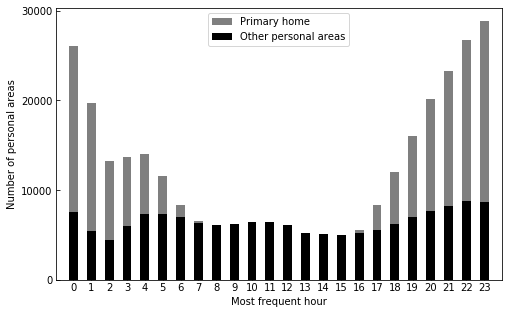

In [47]:
fig,ax=plt.subplots(figsize=(8,5))
id_primary_home_most_freq_hour_pd.groupby('most_freq_hour')['point'].count().plot(ax=ax,kind='bar',color='k',alpha=0.5,label='Primary home')
id_other_most_freq_hour_pd.groupby('most_freq_hour')['point'].count().plot(ax=ax,kind='bar',color='k',alpha=1,label='Other personal areas')
ax.tick_params(which='both',direction='in',pad=3)
ax.locator_params(axis='y',nbins=5)
plt.xticks(rotation=0)
ax.set_xlabel('Most frequent hour')
ax.set_ylabel('Number of personal areas')
ax.set_xlim([-1,24])
ax.legend(loc='best')
plt.savefig(os.path.join(path_to_fig,country,'most-frequent-hours.pdf'),bbox_inches='tight')